<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Capstone - Insult Detection in Social Commentary

Based on the video tutorial **Text Classification with Machine Learning,SpaCy and Scikit(Sentiment Analysis)** by **Jesse E. Agbe (JCharis)**.

## Data Source: Kaggle Competition

### Dataset
- [Sentiment Labelled Sentences Data Set](https://www.kaggle.com/c/detecting-insults-in-social-commentary/data)

### About the Data
The dataset contains sentences labelled with insulting or neutral sentiment.

- Data Set Characteristics: Text
- Number of Instances: 6594
- Area: Social Commentary
- Associated Tasks: Classification
- Missing Values? N/A

### Data Set Information
This dataset was created for the Kaggle Competition held by Imperium for detecting insults in social comentary. The comments have been scraped from a variety of news sites, twitter 

It contains sentences labelled with positive or negative sentiment.

### Details
Score is either 1 (for insult) or 0 (for non-insult)

### Attribute Information
The attributes are text sentences, extracted from social commentary sections of websites/apps, etc.

## Import libraries

In [203]:
## Import Libraries
import pandas as pd

import regex as re
import spacy
import string

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.svm import LinearSVC


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc



import warnings
warnings.filterwarnings('ignore')

import unicodedata
from collections import Counter


## Load data

In [56]:
#Import datasets
df_train = pd.read_csv('/Users/Sam/Desktop/Data Science:AI/Capstone/detecting-insults-in-social-commentary/train.csv')
df_test = pd.read_csv('/Users/Sam/Desktop/Data Science:AI/Capstone/detecting-insults-in-social-commentary/test_with_solutions.csv')
dfs_insult = {'train': df_train, 'test': df_test}

In [60]:
#Drop the 'source' column from training set
df_train.drop('source', axis=1, inplace=True)

In [62]:
#Drop the 'source' column from test set
df_test.drop('source', axis=1, inplace=True)

## Inspect the data

In [63]:
# - assign column names
# - add the data source
# - check the data
for ds in dfs_insult.keys():
    print('Dataset: %s [%d row(s) x %d col(s)]' % (ds, dfs_insult[ds].shape[0], dfs_insult[ds].shape[1]))
    dfs_insult[ds].columns = ['insult', 'text']
    dfs_insult[ds]['source'] = ds
    print(dfs_insult[ds].head())
    print('-' * 75)

Dataset: train [3947 row(s) x 2 col(s)]
   insult                                               text source
0       1                               "You fuck your dad."  train
1       0  "i really don't understand your point.\xa0 It ...  train
2       0  "A\\xc2\\xa0majority of Canadians can and has ...  train
3       0  "listen if you dont wanna get married to a man...  train
4       0  "C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd...  train
---------------------------------------------------------------------------
Dataset: test [2647 row(s) x 2 col(s)]
   insult                                               text source
0       0  "THE DRUDGE REPORT\\n\\n\\n\\nYou won't see th...   test
1       0  "@ian21\xa0"Roger Clemens is the fucking man, ...   test
2       1  "Agree with Alan you are an extremest idiot.  ...   test
3       0  "Really?\\n\\nI see Marc Lamont Hill on variou...   test
4       0  "Really suck isn't the word, when many of our ...   test
-----------------------------

Text(0.5, 1.0, 'Training Data Split')

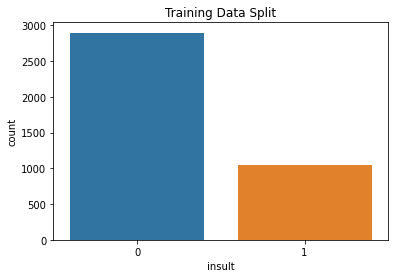

In [64]:
#Plot the training data to show the split of insults vs. non-insults
sns.countplot(df_train['insult'])
plt.title('Training Data Split')

Text(0.5, 1.0, 'Test Data Split')

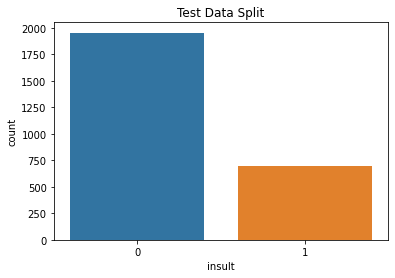

In [65]:
#Plot the test data to show the split of insults vs. non-insults
sns.countplot(df_test['insult'])
plt.title('Test Data Split')

## Merge the data

In [66]:
#Concatenate the Datasets
df = pd.concat(dfs_insult.values(), ignore_index = True)

In [67]:
print('Dataset: %s [%d row(s) x %d col(s)]\n' % ('All', df.shape[0], df.shape[1]))
print(df.info())
print(df.sample(10))
print('-' * 75)

Dataset: All [6594 row(s) x 3 col(s)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6594 entries, 0 to 6593
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   insult  6594 non-null   int64 
 1   text    6594 non-null   object
 2   source  6594 non-null   object
dtypes: int64(1), object(2)
memory usage: 154.7+ KB
None
      insult                                               text source
5426       0  "Yawn.\n\nAnd your thoughts on left wing rank ...   test
5554       1                            "UR  ALL PENIS SUCKERS"   test
1449       0  "In my area the scrap men and women are around...  train
3074       0  "The same bus drivers carried epl players (i.e...  train
194        0        "Yes  you have to have comedy in your life"  train
4171       0  "If United get Kagawa they be one up on the mi...   test
5989       0      "Im going to period blood all over your dick"   test
3394       0  "In the past day we've seen Zombies 

In [68]:
#Check shape of merged DF
df.shape

(6594, 3)

In [69]:
#Check for null values
df.isnull().sum()

insult    0
text      0
source    0
dtype: int64

## Export the data

In [91]:
df.to_csv('/Users/Sam/Downloads/insult_detect_final.csv', index = None)

## Load the spaCy library

In [71]:
nlp = spacy.load('en_core_web_sm')

## Prepare the text
All the text handling and preparation concerned with modifications from raw text into useful data to feed to feature engineering andf eventually, modelling.
- handle encoding (not needed in this instance)
- handle extraneous and international charaters
- Handle puntuation & special characters
- handle symbols
- handle metadata and embeded information (i.e. escape characters/encoding - UTF8, etc.)
- handle repetitions (such multiple spaces or newlines)

In [72]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)

    return text

In [73]:
df['text'] = df['text'].apply(clean_text)

In [74]:
#Check the 'cleaned' text
df.sample(5)

,insult,text,source
5036,1,have another bottle of Ripple and go back to y...,test
4317,1,"Don't sell yourself short, Wayne. You are a cr...",test
6479,0,I don't think you should be silences. I think ...,test
6119,0,jlhanxson:\n\nDon't believe all you read in po...,test
4809,1,You are a total idiot.\xa0 You are probably un...,test


## Work the text
Remove any stopwords, punctuation & digits, lemmatize the words and lowercase all characters with the code below.

In [75]:
def convert_text(text):
    sent = nlp(text)
    ents = {x.text: x for x in sent.ents}
    tokens = []
    for w in sent:
        if w.is_stop or w.is_punct or w.is_digit:
            continue
        if w.text in ents:
            tokens.append(w.text)
        else:
            tokens.append(w.lemma_.lower())
    text = ' '.join(tokens)

    return text

In [77]:
%%time
#Apply the text_conversion function to the df
df['short'] = df['text'].apply(convert_text)

CPU times: user 1min 38s, sys: 3.23 s, total: 1min 42s
Wall time: 1min 57s


In [78]:
#Show the added column
df.head()

,insult,text,source,short
0,1,You fuck your dad.,train,fuck dad
1,0,i really don't understand your point.\xa0 It s...,train,understand point.\xa0 mix apple orange
2,0,A\\xc2\\xa0majority of Canadians can and has b...,train,a\\xc2\\xa0majority Canadians wrong again.\\n\...
3,0,listen if you dont wanna get married to a man ...,train,listen not wanna married man woman dont bother...
4,0,C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1eddn...,train,c\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1eddn...


In [79]:
# function to remove numbers
df['no_digit'] = df['short'].str.replace('\d+', '')


In [80]:
#function to remove lingering newline characters
df['no_newline'] = df['no_digit'].str.replace(r'\\n', ' ')

In [81]:
#Special character removal
def remove_characters(sentence,keep_apostrophes=False):
    sentence = sentence.strip()
    if keep_apostrophes:
        PATTERN = r'[?|$|&|*|%|@|(|)|~|\|/]' # add other characters here tocremove them
        filtered_sentence = re.sub(PATTERN, r'', sentence)
    else:
        PATTERN = r'[^a-zA-Z0-9 ]' # only extract alpha-numeric characters
        filtered_sentence = re.sub(PATTERN, r'', sentence)
    return filtered_sentence

In [82]:
df['no_special'] = df['no_newline'].apply(remove_characters)

In [83]:
df.head(20)

,insult,text,source,short,no_digit,no_newline,no_special
0,1,You fuck your dad.,train,fuck dad,fuck dad,fuck dad,fuck dad
1,0,i really don't understand your point.\xa0 It s...,train,understand point.\xa0 mix apple orange,understand point.\xa mix apple orange,understand point.\xa mix apple orange,understand pointxa mix apple orange
2,0,A\\xc2\\xa0majority of Canadians can and has b...,train,a\\xc2\\xa0majority Canadians wrong again.\\n\...,a\\xc\\xamajority Canadians wrong again.\\n\\n...,a\\xc\\xamajority Canadians wrong again.\ \ un...,axcxamajority Canadians wrong again unless su...
3,0,listen if you dont wanna get married to a man ...,train,listen not wanna married man woman dont bother...,listen not wanna married man woman dont bother...,listen not wanna married man woman dont bother...,listen not wanna married man woman dont bother...
4,0,C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1eddn...,train,c\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1eddn...,c\xec b\uean xu\uedng \u\ub\ueddng bi\uecu t\x...,c\xec b\uean xu\uedng \u\ub\ueddng bi\uecu t\x...,cxec buean xuuedng uubueddng biuecu txecnh cxf...
5,0,"@SDL OK, but I would hope they'd sign him to a...",train,@sdl ok hope sign year contract start chance r...,@sdl ok hope sign year contract start chance r...,@sdl ok hope sign year contract start chance r...,sdl ok hope sign year contract start chance re...
6,0,Yeah and where are you now?,train,yeah,yeah,yeah,yeah
7,1,shut the fuck up. you and the rest of your fag...,train,shut fuck rest faggot friend burn stake,shut fuck rest faggot friend burn stake,shut fuck rest faggot friend burn stake,shut fuck rest faggot friend burn stake
8,1,Either you are fake or extremely stupid...mayb...,train,fake extremely stupid maybe,fake extremely stupid maybe,fake extremely stupid maybe,fake extremely stupid maybe
9,1,That you are an idiot who understands neither ...,train,idiot understand taxation woman health,idiot understand taxation woman health,idiot understand taxation woman health,idiot understand taxation woman health


In [84]:
#Show Original Text
df.iloc[5989,1]

'Im going to period blood all over your dick'

In [86]:
#Show 'Cleaned' text
df.iloc[5989,6]

'be go period blood dick'

In [87]:
#Original text
print(df.iloc[5568,1])

No, Vicky<2.... wrote the pathetic and pathological Beckerhead.\n\nDo you really think that we care what people stupid enough to follow Glenn Beck and self-deceitful enough to rationalize his lies opine about?\n\nDo you? \xa0Are you actually that self-deluded to think that we don't recognize you for what you are, a childish flame warrior obsessed with every comment I write?\n\nAnyone can see here that you're obsessed with me. \xa0Guess you can't stand someone who exposed your hero as the liar, hypocrite, ignorant reactionary propagandist that ignorant and gullible people like you support.\n\nAs a Beckerhead, you have gall to insult anyone's intelligence.


In [88]:
#Show cleaned text
print (df.iloc[5568,4])

vicky< write pathetic pathological beckerhead.\n\ndo think care people stupid follow glenn beck self deceitful rationalize lie opine about?\n\ndo \xaare actually self delude think recognize childish flame warrior obsess comment write?\n\nanyone obsess \xaguess stand expose hero liar hypocrite ignorant reactionary propagandist ignorant gullible people like support.\n\nas beckerhead gall insult intelligence


In [89]:
#Examine difference in string length

string_1 = str(df.iloc[5568,1])
string_2 = str(df.iloc[5568,4])

print(len(string_1)); (len(string_2))

662


408

In [90]:
df.head()

,insult,text,source,short,no_digit,no_newline,no_special
0,1,You fuck your dad.,train,fuck dad,fuck dad,fuck dad,fuck dad
1,0,i really don't understand your point.\xa0 It s...,train,understand point.\xa0 mix apple orange,understand point.\xa mix apple orange,understand point.\xa mix apple orange,understand pointxa mix apple orange
2,0,A\\xc2\\xa0majority of Canadians can and has b...,train,a\\xc2\\xa0majority Canadians wrong again.\\n\...,a\\xc\\xamajority Canadians wrong again.\\n\\n...,a\\xc\\xamajority Canadians wrong again.\ \ un...,axcxamajority Canadians wrong again unless su...
3,0,listen if you dont wanna get married to a man ...,train,listen not wanna married man woman dont bother...,listen not wanna married man woman dont bother...,listen not wanna married man woman dont bother...,listen not wanna married man woman dont bother...
4,0,C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1eddn...,train,c\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1eddn...,c\xec b\uean xu\uedng \u\ub\ueddng bi\uecu t\x...,c\xec b\uean xu\uedng \u\ub\ueddng bi\uecu t\x...,cxec buean xuuedng uubueddng biuecu txecnh cxf...


In [94]:
#Drop unneeded columns
df.drop(['source','short','no_digit','no_newline'], axis=1, inplace=True)

In [95]:
#Rename column
df.rename(columns = {'no_special':'text_final'}, inplace = True) 


## Feature Engineering

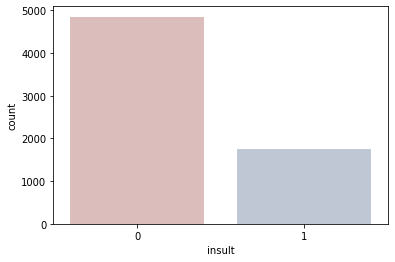

In [96]:
#Show data imbalance
#Countplot of insults vs non-insults
sns.countplot(df['insult'], palette='vlag_r')


### Split Data

In [97]:
# Features and Labels
X = df['text_final']
y = df['insult']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

display(y_train.value_counts(normalize=True))
display(y_test.value_counts(normalize=True))

0    0.735735
1    0.264265
Name: insult, dtype: float64

0    0.736164
1    0.263836
Name: insult, dtype: float64

### Count Vectorizer/Bag-of-Words (BOW) as Features

In [98]:
# create count vectorizer object
counts = CountVectorizer()

# Learn a vocabulary dictionary of all tokens in the raw documents
counts.fit(df['text_final'])

# Transform documents to document-term matrix.
X_train_count = counts.transform(X_train)
X_test_count = counts.transform(X_test)

In [209]:
X_train_count

<5275x20077 sparse matrix of type '<class 'numpy.int64'>'
	with 72201 stored elements in Compressed Sparse Row format>

### TF-IDF as Features

#### Word-level TF-IDF

In [99]:
%%time
# word level tf-idf
tfidf = TfidfVectorizer(analyzer = 'word')
print(tfidf)
#Fit on 
tfidf.fit(df['text_final'])
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

TfidfVectorizer()
CPU times: user 357 ms, sys: 12 ms, total: 369 ms
Wall time: 432 ms


#### N-Gram TF-IDF

In [100]:
%%time
# ngram level tf-idf
tfidf_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3))
print(tfidf_ngram)

tfidf_ngram.fit(df['text_final'])
X_train_tfidf_ngram = tfidf_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_ngram.transform(X_test)

TfidfVectorizer(ngram_range=(2, 3), token_pattern='\\w{1,}')
CPU times: user 1.19 s, sys: 62.9 ms, total: 1.26 s
Wall time: 1.41 s


#### Character-level TF-IDF

In [101]:
%%time
# characters level tf-idf
tfidf_ngram_chars = TfidfVectorizer(analyzer = 'char',
                                         token_pattern = r'\w{1,}',
                                         ngram_range = (2, 3))
print(tfidf_ngram_chars)

tfidf_ngram_chars.fit(df['text_final'])
X_train_tfidf_ngram_chars = tfidf_ngram_chars.transform(X_train)
X_test_tfidf_ngram_chars  = tfidf_ngram_chars.transform(X_test)

TfidfVectorizer(analyzer='char', ngram_range=(2, 3), token_pattern='\\w{1,}')
CPU times: user 2.12 s, sys: 78 ms, total: 2.19 s
Wall time: 2.6 s


### Text/NLP Features/EDA

In [104]:
%%time
df['char_count'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['word_count_final'] = df['text_final'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count'] + 1)
df['punctuation_count'] = df['text'].apply(lambda x: len(''.join(_ for _ in x if _ in string.punctuation))) 
df['title_word_count'] = df['text'].apply(lambda x: len([w for w in x.split() if w.istitle()]))
df['uppercase_word_count'] = df['text'].apply(lambda x: len([w for w in x.split() if w.isupper()]))

CPU times: user 408 ms, sys: 11.9 ms, total: 420 ms
Wall time: 684 ms


In [105]:
df.sample(5)

,insult,text,text_final,char_count,word_count,word_density,punctuation_count,title_word_count,uppercase_word_count,word_count_final
5165,0,Verlander is the best pitcher in baseball but ...,verlander good pitcher baseball ready prime ti...,332,62,5.269841,9,4,1,27
3666,0,That thing looks like Sloth from the Goonies. ...,thing look like sloth goonie scrap new dear ch...,162,32,4.909091,5,7,0,12
3129,1,"You are an evil despicable animal, and I'm sur...",evil despicable animal sure eventually god spe...,128,23,5.333333,5,2,0,11
3472,0,<div class=forum-item forum-reply><div class=f...,div class forum item forum replydiv class f...,181,22,7.869565,18,3,1,18
128,1,"Your still a loser, man we must have really go...",loser man get skin lol,70,14,4.666667,1,1,0,5


In [122]:
#Average Word count by insult - Original Text
df.groupby('insult', as_index=False)['word_count'].mean()


,insult,word_count
0,0,34.224216
1,1,25.558553


In [108]:
#Average Word count by insult - Final clean text
df.groupby('insult', as_index=False)['word_count_final'].mean()

,insult,word_count_final
0,0,17.277411
1,1,12.311137


In [112]:
#Find longest text comment
print(df.query('word_count >= 1000 ')['text'])
#df.iloc[4388,1]

2004    Henry Cisneros - Democrat - U.S. Secretary of ...
3416    Great Scott\\nStephen F. Hayes\\nFebruary 20, ...
4388    The real reason comments sections are limited....
4610    Christi... I hope somehow you do see this comm...
Name: text, dtype: object


In [113]:
#Drop overly long comments with a lot of noise and not much information gain
df.drop([2004, 3416, 4388, 4610], axis=0, inplace=True)


In [123]:
#punctuation count by insult
df.groupby('insult', as_index=False)['punctuation_count'].mean()


,insult,punctuation_count
0,0,10.968028
1,1,7.341561


Text(0.5, 1.0, 'Syntax of an Insult')

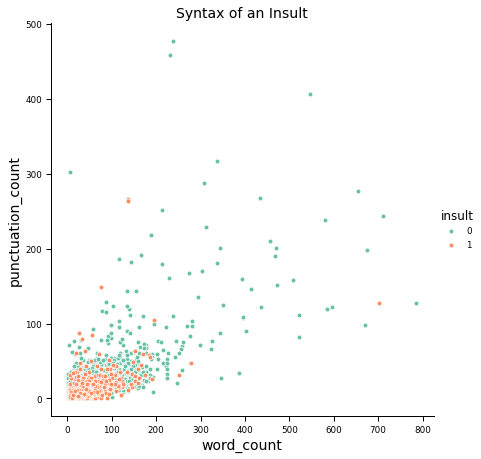

In [126]:
#Plot the Syntax of an insult
sns.set_context("paper", rc={"axes.labelsize":14})
g=sns.pairplot(data=df, hue='insult', x_vars='word_count', y_vars='punctuation_count', height=6, palette='Set2')
plt.title('Syntax of an Insult', size=14)

In [127]:
#Find longest insult
df.loc[(df['word_count']>=650) & (df['insult'] == 1)]

,insult,text,text_final,char_count,word_count,word_density,punctuation_count,title_word_count,uppercase_word_count,word_count_final
3208,1,"Randal, regarding your first paragraph above, ...",randal paragraph articulett said regarde seco...,4014,703,5.701705,128,50,20,253


In [130]:
#Show clean version
df.iloc[3207,2]

'randal paragraph articulett said  regarde second paragraph force argue blog co write book stretch thing suit believe use improbability conclude probability time case   take speculation non believer especially Christians hear  things book Christians consider  things mean sentence aritculett  first come CHRISTIANS scared death seriously doubt faith scared threat hell wrong probably understand time come seriously doubt faith understand point convince faith probability order reject thexa point Pascal wager force investigate thoroughly educated faith investigate likely say book thing Christians consider before  i mountain anecdotal evidence Christian speak learn learn little scenario repeat time disunion Christian see response blog half year period teach teach me  when come non believer general study show non believer know Bible Christians evidence baby probability thereforexa non believer learn book likely otherwise  so speculation evidence evidence talk co write book skirt step order bel

In [131]:
# Initialise some columns for feature's counts
df['adj_count'] = 0
df['adv_count'] = 0
df['noun_count'] = 0
df['num_count'] = 0
df['pron_count'] = 0
df['propn_count'] = 0
df['verb_count'] = 0

In [133]:
%%time
#Using spaCy to populate the columns
# for each text
for i in range(df.shape[0]):
    # convert into a spaCy document
    doc = nlp(df.iloc[i]['text'])
    # initialise feature counters
    c = Counter([t.pos_ for t in doc])

    df.at[i, 'adj_count'] = c['ADJ']
    df.at[i, 'adv_count'] = c['ADV']
    df.at[i, 'noun_count'] = c['NOUN']
    df.at[i, 'num_count'] = c['NUM']
    df.at[i, 'pron_count'] = c['PRON']
    df.at[i, 'propn_count'] = c['PROPN']
    df.at[i, 'verb_count'] = c['VERB']

CPU times: user 1min 36s, sys: 3.37 s, total: 1min 39s
Wall time: 2min 7s


In [134]:
#Set column names
cols = [
    'char_count', 'word_count', 'word_density',
    'punctuation_count', 'title_word_count',
    'uppercase_word_count', 'adj_count',
    'adv_count', 'noun_count', 'num_count',
    'pron_count', 'propn_count', 'verb_count']

df[cols].sample(5)

,char_count,word_count,word_density,punctuation_count,title_word_count,uppercase_word_count,adj_count,adv_count,noun_count,num_count,pron_count,propn_count,verb_count
236,17.0,4.0,3.400000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
3746,206.0,40.0,5.024390,13.0,2.0,0.0,14.0,10.0,30.0,0.0,13.0,13.0,22.0
3092,150.0,27.0,5.357143,10.0,1.0,0.0,5.0,3.0,6.0,0.0,7.0,3.0,8.0
6184,67.0,11.0,5.583333,6.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
157,90.0,16.0,5.294118,4.0,4.0,2.0,0.0,2.0,0.0,1.0,3.0,2.0,4.0


In [135]:
#Number count by insult
df.groupby('insult', as_index=False)['num_count'].mean()

,insult,num_count
0,0.0,0.450701
1,1.0,0.325488


In [136]:
#Proper Noun count by insult
df.groupby('insult', as_index=False)['propn_count'].mean()

,insult,propn_count
0,0.0,3.091790
1,1.0,2.480482


In [137]:
#Verb count by insult
df.groupby('insult', as_index=False)['verb_count'].mean()

,insult,verb_count
0,0.0,4.723185
1,1.0,4.297933


In [138]:
#Create POS Dataframe
POS_df=df[['insult','adj_count', 'adv_count', 'noun_count', 'num_count', 'propn_count', 'verb_count']]
POS_df.head()

,insult,adj_count,adv_count,noun_count,num_count,propn_count,verb_count
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,3.0,0.0,0.0,3.0
2,0.0,6.0,4.0,10.0,0.0,2.0,7.0
3,0.0,5.0,1.0,8.0,0.0,2.0,9.0
4,0.0,0.0,0.0,16.0,4.0,49.0,5.0


In [139]:
POS_df.corr()

,insult,adj_count,adv_count,noun_count,num_count,propn_count,verb_count
insult,1.000000,-0.011929,-0.016129,-0.022538,-0.038404,-0.034045,-0.026143
adj_count,-0.011929,1.000000,0.765390,0.856993,0.408304,0.419867,0.797923
adv_count,-0.016129,0.765390,1.000000,0.762362,0.342953,0.360363,0.842936
noun_count,-0.022538,0.856993,0.762362,1.000000,0.498150,0.501227,0.873819
num_count,-0.038404,0.408304,0.342953,0.498150,1.000000,0.524627,0.406121
propn_count,-0.034045,0.419867,0.360363,0.501227,0.524627,1.000000,0.425840
verb_count,-0.026143,0.797923,0.842936,0.873819,0.406121,0.425840,1.000000


In [143]:
#Describe POS df
POS_df.describe()

,insult,adj_count,adv_count,noun_count,num_count,propn_count,verb_count
count,6590.000000,6594.000000,6594.000000,6594.000000,6594.000000,6594.000000,6594.000000
mean,0.264340,2.243706,2.012284,5.561116,0.417804,2.933576,4.616166
std,0.441015,3.878156,3.426328,8.984101,1.437824,7.920189,7.180914
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,3.000000,0.000000,1.000000,3.000000
75%,1.000000,3.000000,3.000000,6.000000,0.000000,3.000000,5.000000
max,1.000000,77.000000,63.000000,168.000000,47.000000,248.000000,108.000000


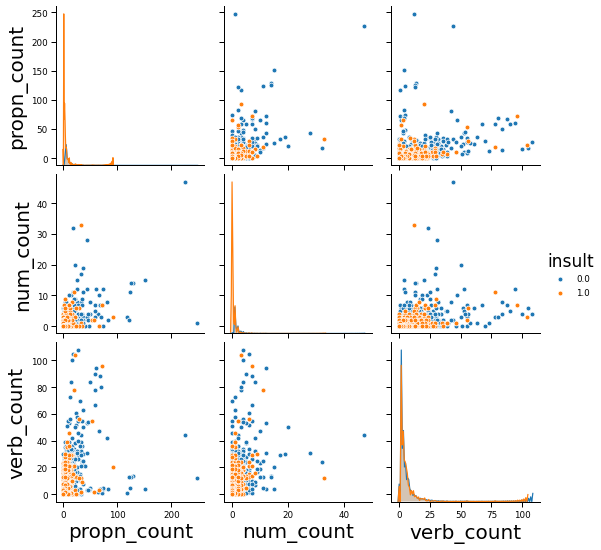

In [148]:
#Pairplot of POS
sns.set_context("paper", rc={"axes.labelsize":20})
sns.pairplot(POS_df, vars=["propn_count", "num_count",'verb_count'], hue="insult", diag_kws={'bw': 0.2})


## Modelling

In [ ]:
# helper function to show results and charts
def show_summary_report(actual, prediction, probabilities):
    
    # If actual labels is a Series, extract the array
    if isinstance(actual, pd.Series):
        actual = actual.values
    # If actual and/or prediction labels are strings, convert to integers
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)
        
    # Calculate model evaluation metrics
    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, prediction)
    f1_score_=f1_score(actual, prediction)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('f1 score : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % f1_score_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Plot Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Plot Precision/Recall curve
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # Plot ROC curve
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_,f1_score_)

In [227]:
## helper function for training models

def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    probability = classifier.predict_proba(feature_vector_valid)
    
    #Calc. eval scores
    accuracy_ = accuracy_score(y_test, predictions)
    precision_ = precision_score(y_test, predictions)
    recall_ = recall_score(y_test, predictions)
    roc_auc_ = roc_auc_score(y_test, predictions)
    f1_score_ = f1_score(y_test, predictions)
    
    return (accuracy_,
            precision_,
            recall_,
            roc_auc_)
    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')
    

In [150]:
# Keep the results in a dataframe
results_1 = pd.DataFrame(columns = ['Count Vectors',
                                  'WordLevel TF-IDF',
                                  'N-Gram Vectors',
                                  'CharLevel Vectors'])

#### Naive Bayes Classifier

In [220]:
%%time

#Import NB Classifier from Sklearn
from sklearn.naive_bayes import MultinomialNB

#print('NB, Count Vector : %.4f\n' % accuracy1)

# Naive Bayes on Count Vectors
accuracy1 = train_model(MultinomialNB(), X_train_count, y_train, X_test_count

print(accuracy1)

(0.7975739196360879, 0.6167146974063401, 0.6149425287356322, 0.7389851675604011)
CPU times: user 5.53 s, sys: 1.13 s, total: 6.66 s
Wall time: 8.73 s


In [212]:
%%time
# Naive Bayes on Word Level TF IDF Vectors
accuracy2 = train_model(MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf)

print(accuracy2)
#print('NB, WordLevel TF-IDF : %.4f\n' % accuracy2)


(0.756633813495072, 0.8461538461538461, 0.09482758620689655, 0.5443241947512341)
CPU times: user 13.3 ms, sys: 5.41 ms, total: 18.7 ms
Wall time: 16.9 ms


In [185]:
%%time
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy3 = train_model(MultinomialNB(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
#print('NB, N-Gram Vectors   : %.4f\n' % accuracy3)
print(accuracy3)

(0.733131159969674, 0.16666666666666666, 0.0028735632183908046, 0.4988621163156835)
CPU times: user 24.6 ms, sys: 10.8 ms, total: 35.4 ms
Wall time: 35.2 ms


In [186]:
%%time
# # Naive Bayes on Character Level TF IDF Vectors
accuracy4 = train_model(MultinomialNB(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
#print('NB, CharLevel Vectors: %.4f\n' % accuracy4)
print(accuracy4)

(0.7611827141774071, 0.8367346938775511, 0.11781609195402298, 0.5547885815073925)
CPU times: user 18.3 ms, sys: 11.7 ms, total: 29.9 ms
Wall time: 28 ms


In [187]:
results_1.loc['Naïve Bayes'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

#### Support Vector Classifier

In [214]:
%%time
# Support Vector Machine on Count Vectors
accuracy1 = train_model(LinearSVC(), X_train_count, y_train, X_test_count)
#print('SVM, Count Vectors    : %.4f\n' % accuracy1)
print(accuracy1)


(0.8104624715693708, 0.6467065868263473, 0.6206896551724138, 0.7495827266593273)
CPU times: user 186 ms, sys: 6.12 ms, total: 192 ms
Wall time: 220 ms


In [189]:
%%time
# Support Vector Machine on Word Level TF IDF Vectors
accuracy2 = train_model(LinearSVC(), X_train_tfidf, y_train, X_test_tfidf)
#print('SVM, WordLevel TF-IDF : %.4f\n' % accuracy2)
print(accuracy2)

(0.8248673237300985, 0.7427385892116183, 0.514367816091954, 0.7252580584064301)
CPU times: user 40.2 ms, sys: 3.05 ms, total: 43.2 ms
Wall time: 71.3 ms


In [190]:
%%time
# Support Vector Machine on Ngram Level TF IDF Vectors
accuracy3 = train_model(LinearSVC(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
#print('SVM, N-Gram Vectors   : %.4f\n' % accuracy3)
print(accuracy3)

(0.7422289613343442, 0.8333333333333334, 0.028735632183908046, 0.5133379499745493)
CPU times: user 87.4 ms, sys: 4.36 ms, total: 91.7 ms
Wall time: 90.7 ms


In [191]:
%%time
# Support Vector Machine on Character Level TF IDF Vectors
accuracy4 = train_model(LinearSVC(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
#print('SVM, CharLevel Vectors: %.4f\n' % accuracy4)
print(accuracy4)

(0.8188021228203184, 0.6981818181818182, 0.5517241379310345, 0.7331226250932206)
CPU times: user 169 ms, sys: 11.8 ms, total: 181 ms
Wall time: 193 ms


In [192]:
results_1.loc['Support Vector Machine'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

#### Linear Classifier

In [204]:
%%time
# Linear Classifier on Count Vectors
accuracy1 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 350), X_train_count, y_train, X_test_count)
#print('LR, Count Vectors    : %.4f\n' % accuracy1)
print(accuracy1)

(0.8347232752084913, 0.7708333333333334, 0.5316091954022989, 0.7374832794725191)
CPU times: user 506 ms, sys: 75.5 ms, total: 581 ms
Wall time: 482 ms


In [205]:
%%time
# Linear Classifier on Word Level TF IDF Vectors
accuracy2 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 100), X_train_tfidf, y_train, X_test_tfidf)
#print('LR, WordLevel TF-IDF : %.4f\n' % accuracy2)
print(accuracy2)

(0.8059135708870356, 0.8432835820895522, 0.32471264367816094, 0.6515427276063307)
CPU times: user 339 ms, sys: 16.2 ms, total: 355 ms
Wall time: 248 ms


In [206]:
%%time
# Linear Classifier on Ngram Level TF IDF Vectors
accuracy3 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 100), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
#print('LR, N-Gram Vectors   : %.4f\n' % accuracy3)
print(accuracy3)

(0.7369219105382866, 1.0, 0.0028735632183908046, 0.5014367816091954)
CPU times: user 1.21 s, sys: 100 ms, total: 1.31 s
Wall time: 829 ms


In [207]:
%%time
# Linear Classifier on Character Level TF IDF Vectors
accuracy4 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 100), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
#print('LR, CharLevel Vectors: %.4f\n' % accuracy4)
print(accuracy4)


(0.8165276724791509, 0.8192771084337349, 0.39080459770114945, 0.6799543070895037)
CPU times: user 267 ms, sys: 36.9 ms, total: 304 ms
Wall time: 231 ms


#### Undersampling - Bag of Words

In [221]:
#Undersampling BOW
# Random undersampling to balance the class distribution
from imblearn.under_sampling import RandomUnderSampler
# summarize class distribution
print(Counter(y_train))
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_train_count_under, y_train_under = undersample.fit_resample(X_train_count, y_train)
# summarize class distribution
print(Counter(y_train_under))

Counter({0: 3881, 1: 1394})
Counter({0: 1394, 1: 1394})


#### Undersampling tf-idf - Word

In [232]:
#Undersampling tf-idf (word/unigram)
# Random undersampling to balance the class distribution
from imblearn.under_sampling import RandomUnderSampler
# summarize class distribution
print(Counter(y_train))
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_train_tfidf_under, y_train_under = undersample.fit_resample(X_train_tfidf, y_train)
# summarize class distribution
print(Counter(y_train_under))

Counter({0: 3881, 1: 1394})
Counter({0: 1394, 1: 1394})


#### Undersampling tf-idf - N_gram

In [238]:
#Undersampling tf-idf (N_gram)
# Random undersampling to balance the class distribution
from imblearn.under_sampling import RandomUnderSampler
# summarize class distribution
print(Counter(y_train))
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_train_tfidf_ngram_under, y_train_under = undersample.fit_resample(X_train_tfidf_ngram, y_train)
# summarize class distribution
print(Counter(y_train_under))


Counter({0: 3881, 1: 1394})
Counter({0: 1394, 1: 1394})


#### Undersampling tf-idf - Character

In [244]:
#Undersampling tf-idf (N_gram)
# Random undersampling to balance the class distribution
from imblearn.under_sampling import RandomUnderSampler
# summarize class distribution
print(Counter(y_train))
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_train_tfidf_ngram_chars_under, y_train_under = undersample.fit_resample(X_train_tfidf_ngram_chars, y_train)
# summarize class distribution
print(Counter(y_train_under))

Counter({0: 3881, 1: 1394})
Counter({0: 1394, 1: 1394})


#### Naive Bayes w. Undersampling

##### Bag of Words

Accuracy : 0.7051 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.4683 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8707 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7582                                                                     Best: 1, Worst: < 0.5
f1 score : 0.6090 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


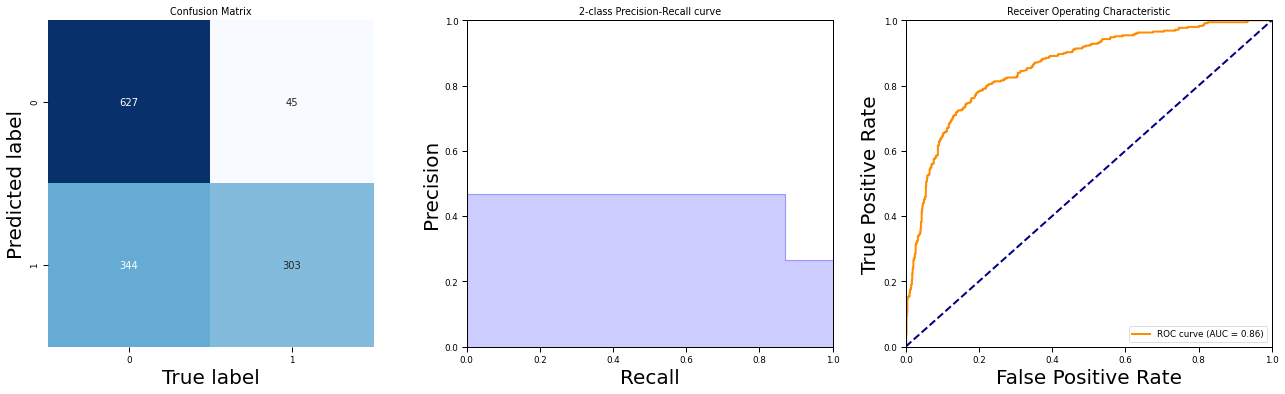

CPU times: user 1.41 s, sys: 451 ms, total: 1.87 s
Wall time: 2.5 s


(0.7050796057619408,
 0.46831530139103555,
 0.8706896551724138,
 0.7582078553925922,
 0.6090452261306533)

In [236]:
%%time
#NB Undersampled with BOW

#Import NB Classifier from Sklearn
from sklearn.naive_bayes import MultinomialNB

#Create MNB Instance

mnb=MultinomialNB()

#Fit NB model on undersampled data
mnb.fit(X_train_count_under,y_train_under)

# make predictions based on the test data
predictions = mnb.predict(X_test_count)
    #(B.todense())

# store probabilities of predictions being 1
probabilities = mnb.predict_proba(X_test_count.todense())[:, 1]

show_summary_report(y_test, predictions, probabilities)

# TF-idf (Unigram) - Best Performing Model

Accuracy : 0.7498 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.5153 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8707 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7886                                                                     Best: 1, Worst: < 0.5
f1 score : 0.6474 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


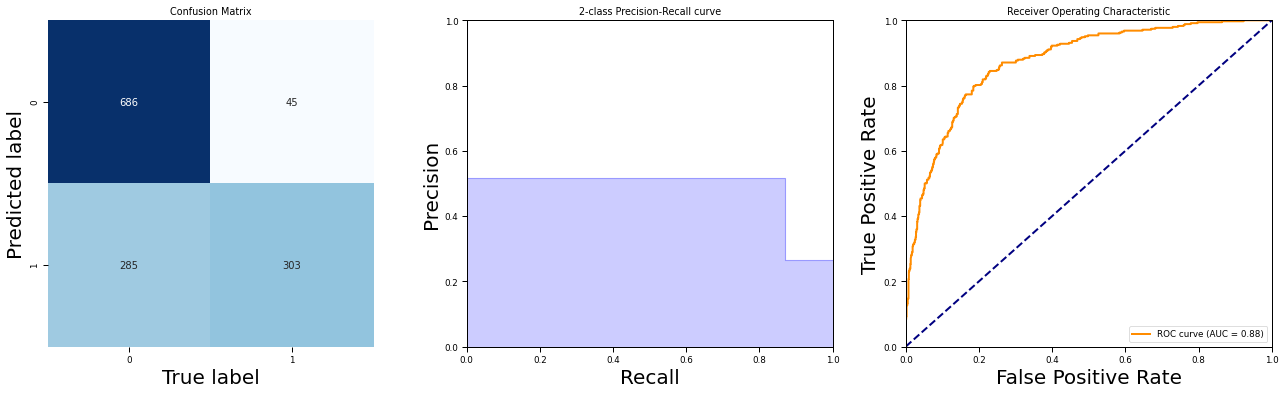

[1 1 0 ... 0 1 0]
CPU times: user 1.57 s, sys: 311 ms, total: 1.88 s
Wall time: 2.64 s


In [250]:
%%time
#NB Undersampled with tf-idf

#Import NB Classifier from Sklearn
from sklearn.naive_bayes import MultinomialNB

#Create MNB Instance

mnb=MultinomialNB()

#Fit NB model on undersampled data
mnb.fit(X_train_tfidf_under,y_train_under)

# make predictions based on the test data
predictions = mnb.predict(X_test_tfidf)
    #(B.todense())

# store probabilities of predictions being 1
probabilities = mnb.predict_proba(X_test_tfidf.todense())[:, 1]

show_summary_report(y_test, predictions, probabilities)

In [254]:
#Create a DF of this best model for predicted & actual values to compare results of insults
predictions = mnb.predict(X_test_tfidf)
results_df = pd.DataFrame({'actual': y_test, 'preds': predictions, 'comment':X_test})


In [255]:
#df head
results_df.head()

,actual,preds,comment
5408,0,1,lol allkpop decide use pic Tiffany fuck dimension
4754,1,1,people racist idiot mad momma want nice black ...
757,0,0,luke babbitt funniest tweet read year luke bab...
939,0,0,remember hater scream rid Blanton season now n...
2795,0,1,matter sloppy


In [257]:
#Check df shape
results_df.shape

(1319, 3)

In [260]:
#Check dtypes
results_df.dtypes

actual      int64
preds       int64
comment    object
dtype: object

In [261]:
#Create differentual to slice rows that were misclassified
results_df['misclassified'] = (results_df['actual'] -- results_df['preds'])

In [262]:
#Check head
results_df.head()

,actual,preds,comment,misclassified
5408,0,1,lol allkpop decide use pic Tiffany fuck dimension,1
4754,1,1,people racist idiot mad momma want nice black ...,2
757,0,0,luke babbitt funniest tweet read year luke bab...,0
939,0,0,remember hater scream rid Blanton season now n...,0
2795,0,1,matter sloppy,1


In [267]:
#Subset dataframe 
results_misclass_df = results_df[(results_df['misclassified'] == 1)&(results_df['actual']==1)]

In [268]:
#Shape shows 45 misclassified insults
results_misclass_df.shape

(45, 4)

In [269]:
#Export this DF to create wordcloud in Google Colab (unable to do so on my machine) on misclassified insults
results_misclass_df.to_csv('/Users/Sam/Downloads/misclassified_insults_final.csv', index = None)

In [270]:
#Export results doc for Worcloud too
results_df.to_csv('/Users/Sam/Downloads/results_final_df.csv', index = None)

##### TF-idf (Bi/Tri_grams)

Accuracy : 0.3912 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.2884 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8908 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.5515                                                                     Best: 1, Worst: < 0.5
f1 score : 0.4357 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


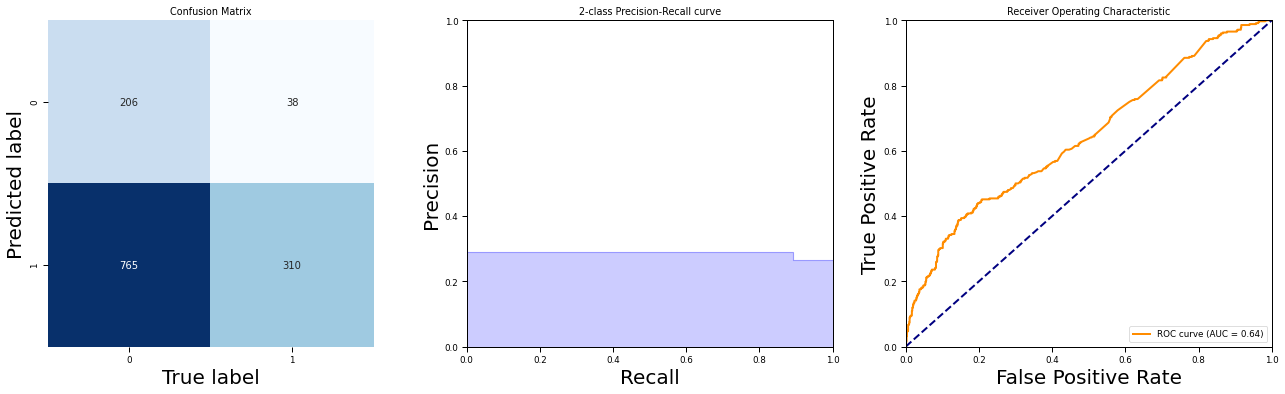

CPU times: user 3.05 s, sys: 2.56 s, total: 5.61 s
Wall time: 7.28 s


(0.3912054586808188,
 0.28837209302325584,
 0.8908045977011494,
 0.5514785089432627,
 0.4356992269852425)

In [242]:
%%time
#NB Undersampled with tf-idf

#Import NB Classifier from Sklearn
from sklearn.naive_bayes import MultinomialNB

#Create MNB Instance

mnb=MultinomialNB()

#Fit NB model on undersampled data
mnb.fit(X_train_tfidf_ngram_under,y_train_under)

# make predictions based on the test data
predictions = mnb.predict(X_test_tfidf_ngram)
    #(B.todense())

# store probabilities of predictions being 1
probabilities = mnb.predict_proba(X_test_tfidf_ngram.todense())[:, 1]

show_summary_report(y_test, predictions, probabilities)

##### Tf-idf (Character-level)

Accuracy : 0.7945 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.5902 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7241 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7720                                                                     Best: 1, Worst: < 0.5
f1 score : 0.6503 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


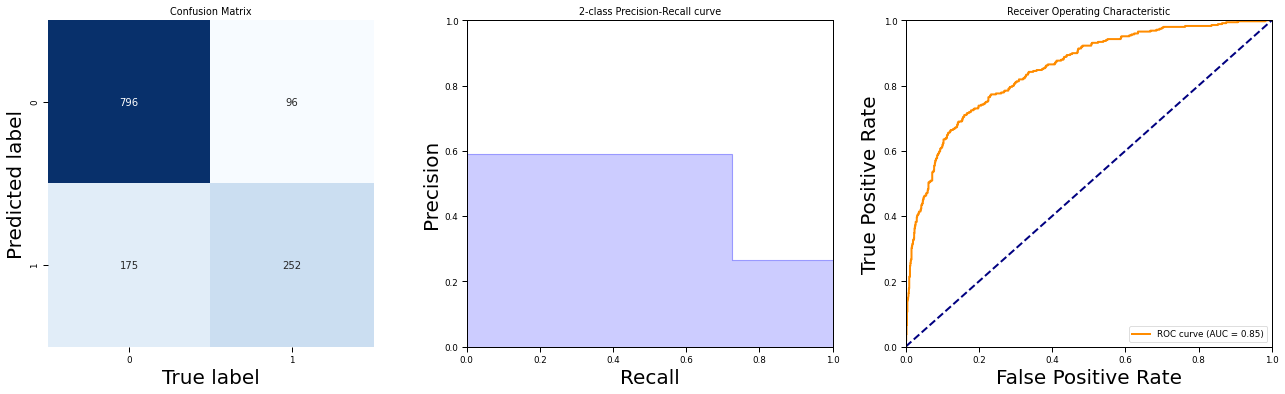

CPU times: user 1.47 s, sys: 206 ms, total: 1.68 s
Wall time: 1.9 s


(0.7945413191811979,
 0.5901639344262295,
 0.7241379310344828,
 0.7719556802443268,
 0.6503225806451612)

In [245]:
%%time
#NB Undersampled with tf-idf

#Import NB Classifier from Sklearn
from sklearn.naive_bayes import MultinomialNB

#Create MNB Instance

mnb=MultinomialNB()

#Fit NB model on undersampled data
mnb.fit(X_train_tfidf_ngram_chars_under,y_train_under)

# make predictions based on the test data
predictions = mnb.predict(X_test_tfidf_ngram_chars)
    #(B.todense())

# store probabilities of predictions being 1
probabilities = mnb.predict_proba(X_test_tfidf_ngram_chars.todense())[:, 1]

show_summary_report(y_test, predictions, probabilities)

#### SVC with Undersampling

##### Bag of Words

Accuracy : 0.7665 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.5397 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7816 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7713                                                                     Best: 1, Worst: < 0.5
f1 score : 0.6385 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


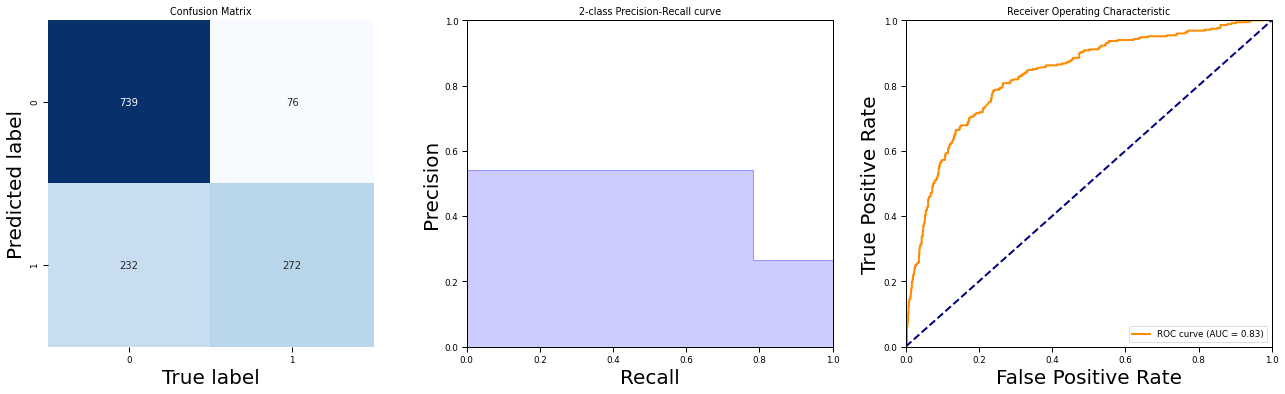

(0.7664897649734648,
 0.5396825396825397,
 0.7816091954022989,
 0.7713401280821999,
 0.6384976525821596)

In [246]:
#SVC Undersampled data with BOW features

#Create Classifier
svc = SVC(kernel='linear', probability=True)

#Fit classifier
svc.fit(X_train_count_under, y_train_under)

# make predictions based on the test data
predictions = svc.predict(X_test_count)

# store probabilities of predictions being 1
probabilities = svc.predict_proba(X_test_count.todense())[:, 1]

show_summary_report(y_test, predictions, probabilities)

##### TF-idf (Unigram)

Accuracy : 0.8097 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.6180 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7299 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7841                                                                     Best: 1, Worst: < 0.5
f1 score : 0.6693 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


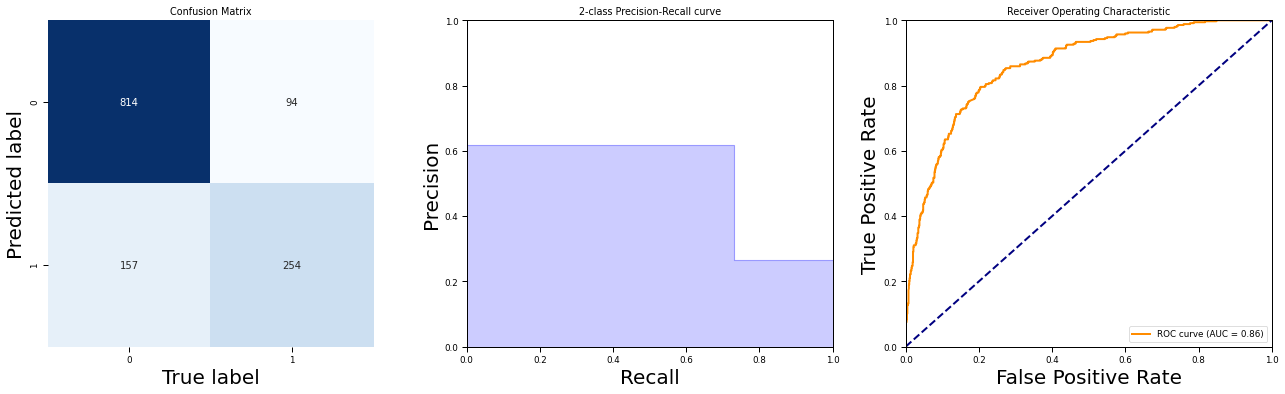

(0.8097043214556482,
 0.6180048661800487,
 0.7298850574712644,
 0.7840980385193603,
 0.6693017127799736)

In [247]:
#SVC Undersampled data with Tf-idf (words) features

#Create Classifier
svc = SVC(kernel='linear', probability=True)

#Fit classifier
svc.fit(X_train_tfidf_under, y_train_under)

# make predictions based on the test data
predictions = svc.predict(X_test_tfidf)

# store probabilities of predictions being 1
probabilities = svc.predict_proba(X_test_tfidf.todense())[:, 1]

show_summary_report(y_test, predictions, probabilities)

##### Tf-idf (Bi/Tri_grams)

Accuracy : 0.7392 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.5085 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.3420 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.6118                                                                     Best: 1, Worst: < 0.5
f1 score : 0.4089 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


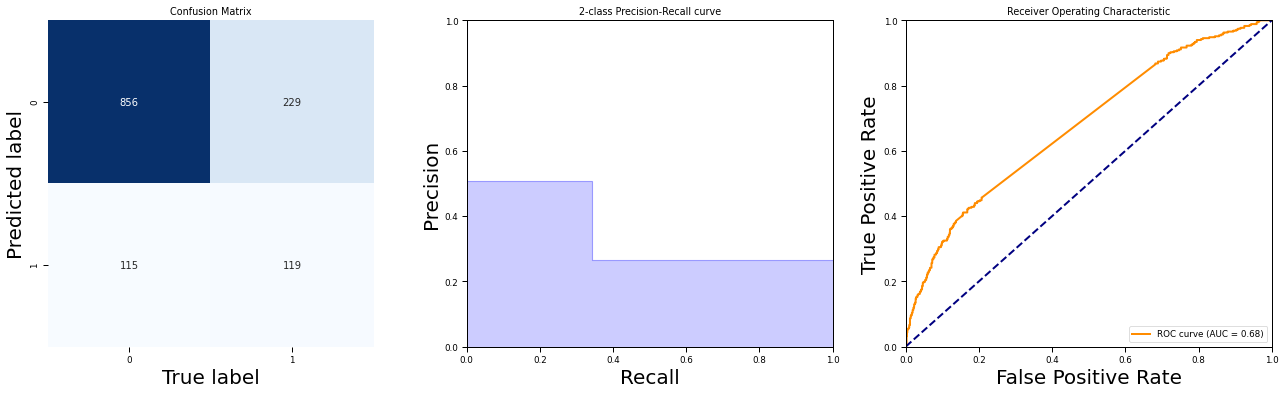

(0.7391963608794542,
 0.5085470085470085,
 0.34195402298850575,
 0.6117597097434805,
 0.40893470790378006)

In [248]:
#SVC Undersampled data with Tf-idf (bi/tri_gram) features

#Create Classifier
svc = SVC(kernel='linear', probability=True)

#Fit classifier
svc.fit(X_train_tfidf_ngram_under, y_train_under)

# make predictions based on the test data
predictions = svc.predict(X_test_tfidf_ngram)

# store probabilities of predictions being 1
probabilities = svc.predict_proba(X_test_tfidf_ngram.todense())[:, 1]

show_summary_report(y_test, predictions, probabilities)

##### Tf-idf (Characters)

Accuracy : 0.7953 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.5859 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7644 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7854                                                                     Best: 1, Worst: < 0.5
f1 score : 0.6633 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


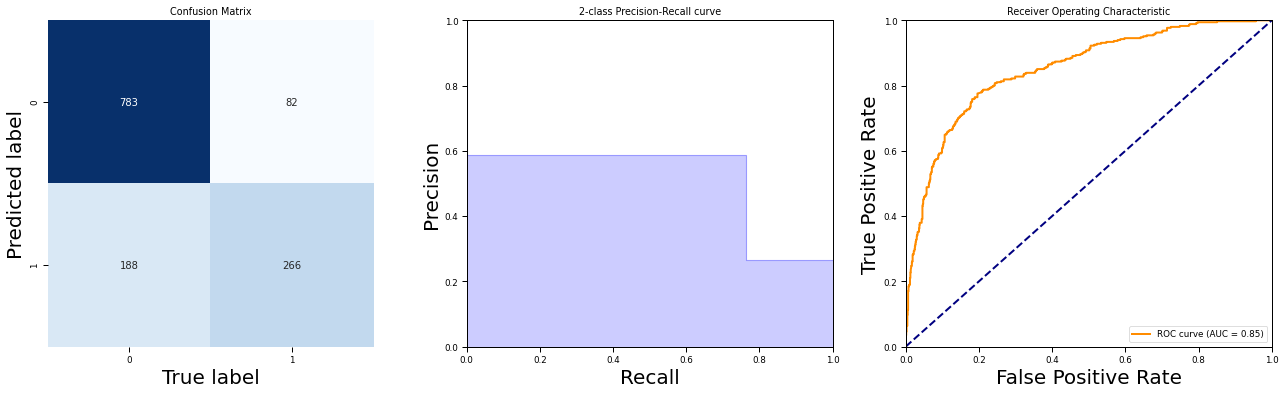

(0.7952994692949203,
 0.5859030837004405,
 0.764367816091954,
 0.7853764930099317,
 0.6633416458852869)

In [249]:
#SVC Undersampled data with Tf-idf (Character) features

#Create Classifier
svc = SVC(kernel='linear', probability=True)

#Fit classifier
svc.fit(X_train_tfidf_ngram_chars_under, y_train_under)

# make predictions based on the test data
predictions = svc.predict(X_test_tfidf_ngram_chars)

# store probabilities of predictions being 1
probabilities = svc.predict_proba(X_test_tfidf_ngram_chars.todense())[:, 1]

show_summary_report(y_test, predictions, probabilities)